# UBC OCEAN Classifier - Training 5x1024 Random Tiles - GPU Enabled 

* Issue with using pyvips on GPU resolved!
* See config for model parameters


# Config

In [24]:
class Config():
    seed = 12
    folds = 4
    epochs = 5
    arch = 'convnext_tiny_in22k'
    lr = .04
    

# Installs

In [1]:
# For IEEE style plotting
!pip install /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl

Processing /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl


In [2]:
# !ls /kaggle/input/pyvips-python-and-deb-package

# !dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package/linux_packages/archives/*.deb

# !pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package/python_packages/ --no-index
# !pip list | grep pyvips

!sudo apt-get update
!sudo apt-get install -y libvips


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [624 kB]
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:4 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:5 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [553 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]      
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]        
Get:9 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [1301 B]    
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]     
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1204 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd

In [3]:
!pip install pyvips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.6/633.6 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyvips: filename=pyvips-2.2.1-py2.py3-none-any.whl size=54177 sha256=4d9da7f93bcec93c0472aa2f3f892f273298c5d7eb76e12d73365ab9ef13e006
  Stored in directory: /root/.cache/pip/wheels/53/a1/9e/895a8ca1f7881a879a8841047d32250e03f3ec7444539c7ce3
Successfully built pyvips


# Imports

In [4]:
import fastai
from fastai.vision.all import *
fastai.__version__

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'2.7.12'

In [5]:
import os
import gc
import shutil
from glob import glob
from os import path

import cv2
import numpy as np
import pandas as pd

import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science','no-latex'])
import seaborn as sns
import plotly.express as px

from tqdm.auto import tqdm

pd.set_option('display.float_format', '{:.2f}'.format)

import pyvips
pyvips.__version__

'2.2.1'

# Load Data

* There are four folders, train_images, train_thumbnails, test_images, test_thumbnails
    * There are 538 files in the train images folder, and 513 in the train_thumbnails folder
    * There is only one file in each of the test images/thumbnails folders.  It has the same label (41).
* There are three csv files, train, test, and sample_submission

Why do we have the thumbnails...to make training faster?

In [6]:
top_dir = '/kaggle/input/UBC-OCEAN'
new_train_dir = '/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled'

train = pd.read_csv(top_dir + '/train.csv')
test = pd.read_csv(top_dir + '/test.csv')
ss = pd.read_csv(top_dir + '/sample_submission.csv')

## Train/Test Csv files EDA

In [7]:
print(f'Size of training data: {train.shape}')
display(train.head())
display(test.head())

Size of training data: (538, 5)


,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


,image_id,image_width,image_height
0,41,28469,16987


## Label Distribution

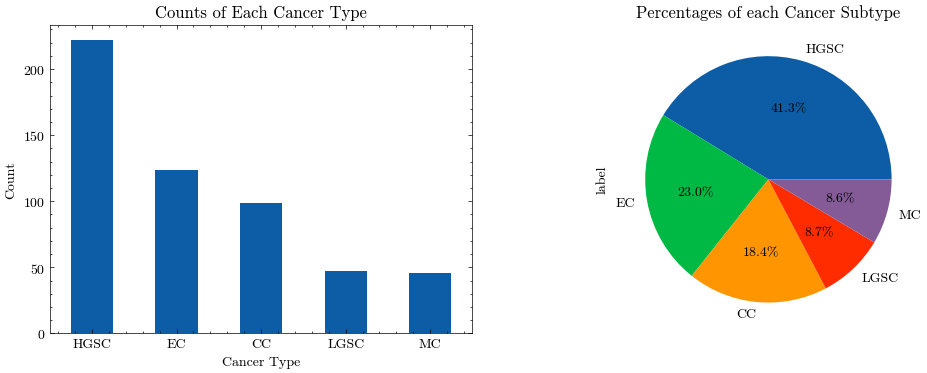

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
train['label'].value_counts().plot(kind='bar', xlabel='Cancer Type', ylabel='Count', rot=0)
plt.title('Counts of Each Cancer Type')
plt.subplot(1,2,2)
train['label'].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label")
plt.title('Percentages of each Cancer Subtype');

## Add new path to images 
* With 512 pixel center tiles
* remove empty images better since implemented retries

## Make a list of files and remove empty images

In [9]:
# make a list of all files in the dataset
train_files = glob(new_train_dir + '/**/*.png',recursive=True)
train_files = [file for file in train_files if '__results' not in file]  # will fix this on the next dataset

# for file in train_files:
#     if '__results' in file:
#         os.remove(file)
        
len(train_files)


2690

In [10]:
img_ids, labels = [],[]

for file in train_files:
    img_ids.append(file.split('/')[-1].split('_')[0])
    labels.append(file.split('/')[-2])

data = list(zip(img_ids,labels,train_files))
            
new_train = pd.DataFrame(data,columns=['img_id','label','img_path'])
new_train.head()

,img_id,label,img_path
0,11557,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/11557_0.png
1,33976,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/33976_2.png
2,37385,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/37385_0.png
3,39258,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_0.png
4,39258,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_2.png


<Axes: xlabel='label'>

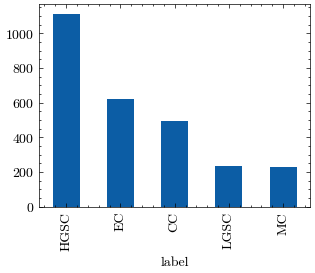

In [11]:
new_train.label.value_counts().plot(kind='bar')

# Model
* The goal is to start with Fastai and the thumbnail images
    * Then use the larger images, deal with tiling, etc.
    * First need to create a subfolder structure which loads the correct thumbnails into the correct folders

## Fastai Model Setup

In [12]:
from fastai.vision.all import *
import timm

In [13]:
from sklearn.model_selection import StratifiedKFold
num_folds = config.folds
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=12)

In [14]:
%%time
preds = []
acc_val = []
epochs = 5
lr = .035
#arch = 'vit_small_patch16_224' # 'vit_base_patch16_224'
#arch = "microsoft/swin-tiny-patch4-window7-224"
#arch = 'swin_base_patch4_window7_224_in22k'
#arch = 'vit_base_patch16_224'
arch = 'convnext_tiny_in22k'

fold = 1

for train_index,val_index in skf.split(new_train.index,new_train['label']):
    
    # get set validation true/false column
    v = []
    for i in range(new_train.shape[0]):
        if i in val_index:
            v.append(True)
        else:
            v.append(False)

    new_train['validation'] = v

    # create a dataloader
#     dls = ImageDataLoaders.from_df(df, path, valid_col='validation',fn_col='image', label_col='label',
#                                    item_tfms=Resize(280), 
#                                    batch_tfms=aug_transforms(size=224, flip_vert=True))#.split_by_idxs(train_idx=train_index, valid_idx=val_index)
    
    dls = ImageDataLoaders.from_df(new_train,path='/',valid_col='validation',fn_col='img_path', label_col='label', seed=12,
                                   #item_tfms=Resize(280, method='squish'),
                                   item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                                   #batch_tfms=aug_transforms(size=224, max_rotate=180)
                                   )
                                                                    
#     dls = DataBlock(
#                     blocks=(ImageBlock, CategoryBlock),  #input is an image, output is a category
#                     get_items = get_image_files,   #returns a list of all images files path
#                     splitter=RandomSplitter(valid_pct=0.2, seed=12),  # set size of validation set (randomly)
#                     get_y = parent_label,   # how do we know the correct label?  This function returns the parent folder of the path
#                     item_tfms=[Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)]  # most architectures need all images the same size
#                     ).dataloaders(path)   #dataloaders are what pytorch uses to feed the training algo.
    
    
    learn = vision_learner(dls, config.arch, metrics=accuracy, path='.').to_fp16()  # vision transformer
    learn.fine_tune(config.epochs, config.lr)
    loss,acc = learn.validate()
    acc_val.append([loss,acc])
    
    #tst_dl = dls.test_dl(tst_files)
    # We will use test time augmentation...
    #tta_preds,_ = learn.tta(dl=tst_dl)
    
    #preds.append(tta_preds)
    # get max probability per row....later I think
    # pred_idxs = tta_preds.argmax(dim=1)
    
    fold +=1
    
    gc.collect()
    
# with arch = 'vit_base_patch16_224', lb = .25
# with 'vit_small_patch16_224'

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,accuracy,time
0,2.093540,2.848409,0.465082,01:09


epoch,train_loss,valid_loss,accuracy,time
0,1.417677,1.265318,0.609212,01:04
1,1.302825,1.849299,0.554235,01:03
2,1.127425,1.148206,0.643388,01:03
3,0.796339,1.028295,0.673105,01:03
4,0.529197,0.958415,0.699851,01:03


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,accuracy,time
0,2.029101,2.266337,0.436850,01:00


epoch,train_loss,valid_loss,accuracy,time
0,1.470865,1.377081,0.609212,01:03
1,1.433949,1.762188,0.531946,01:03
2,1.224088,1.322627,0.625557,01:04
3,0.860219,1.030682,0.717682,01:03
4,0.583116,0.919271,0.722140,01:03


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,accuracy,time
0,2.126917,2.166089,0.501488,01:02


epoch,train_loss,valid_loss,accuracy,time
0,1.485227,1.748432,0.559524,01:04
1,1.354533,1.346670,0.584821,01:03
2,1.104023,1.363936,0.607143,01:13
3,0.795033,0.996840,0.651786,01:16
4,0.532776,0.987759,0.674107,01:16


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,accuracy,time
0,2.180667,3.105455,0.477679,01:15


epoch,train_loss,valid_loss,accuracy,time
0,1.464607,1.919434,0.425595,01:15
1,1.365638,1.353927,0.583333,01:15
2,1.112622,1.452214,0.632440,01:16
3,0.781595,1.004623,0.690476,01:16
4,0.508392,1.064754,0.684524,01:17


CPU times: user 12min 14s, sys: 3min 44s, total: 15min 58s
Wall time: 28min 36s


In [15]:
# above is training on .025 lr with 1024 images

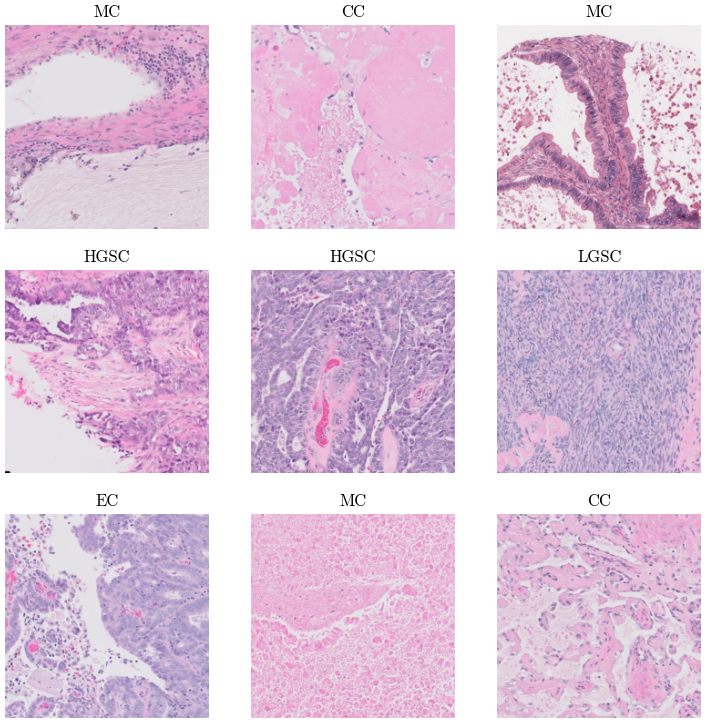

In [16]:
# how I did it with the snakes classifier

# dls = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),  #input is an image, output is a category
#     get_items = get_image_files,   #returns a list of all images files path
#     splitter=RandomSplitter(valid_pct=0.2, seed=12),  # set size of validation set (randomly)
#     get_y = parent_label,   # how do we know the correct label?  This function returns the parent folder of the path
#     item_tfms=[Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)]  # most architectures need all images the same size
# ).dataloaders(path)   #dataloaders are what pytorch uses to feed the training algo.

dls.show_batch(max_n=9) # shows the input (picture) and the label


In [17]:
# learn = vision_learner(dls,resnet18,metrics=error_rate)
# learn.fine_tune(3)

In [18]:
# #learn.lr_find(suggest_funcs=(valley, slide))
# loss,acc = learn.validate()
learn.dls.vocab

['CC', 'EC', 'HGSC', 'LGSC', 'MC']

In [19]:
acc_val = np.array(acc_val)
acc_val

array([[0.95841485, 0.69985139],
       [0.91927063, 0.72213966],
       [0.98775899, 0.67410713],
       [1.06475389, 0.68452382]])

In [20]:
print(f'Mean acc is: {np.mean(acc_val[:,1]):.5f}, Mean Loss is {np.mean(acc_val[:,0]):.3f}, std is: {np.std(acc_val[:,1]):.5f}')

# mean .53883 with no scaling
# Mean is .44932 next run (.05 lr)...This verifies that randomness is greater for scores than scaling, but do another
# still lr =.05, mean is .48695
# again, .47521 (this just doesn't seem like a great optimized solution)
# try .01, .50498, looks like this set has worse images

Mean acc is: 0.69516, Mean Loss is 0.983, std is: 0.01807


In [22]:
# save so I can infer in the next notebook.  downloaded this file 11/14/23 3:38pm
learn.export(fname=f'5x1024_tma2x_{config.arch}_{config_epochs}_epochs_{config.lr}_lr.pkl')